In [2]:
#import arcpy                # the arcpy for your local Pro
import pandas
from arcgis.gis import GIS  # the submodule for displaying maps in jupyter
import arcgis               # the python api module (online processing)
from urllib import request  # module for requesting data from url
import datetime             # gets today's date and past dates
#import json
from shapely.geometry import Point # needed to create shapefiles
import geopandas

import shutil                # needed to zip shapefiles

In [8]:
gis = GIS('http://yalemaps.maps.arcgis.com', 'jill.kelly_yalemaps', 'password')
print("logged in as " + str(gis.properties.user.username))

logged in as jill.kelly_yalemaps


In [4]:
NN = 2 #number of days past to consider (present day is omitted because it may not exist yet)

In [5]:
datelist = []
dashdatelist = []
for N in range(int(NN)):
    date = datetime.datetime.now() - datetime.timedelta(days=N)
    
    year = date.year
    month = date.month
    day = date.day
    if day < 10: day_2digit = "0" + str(day)
    else: day_2digit = str(day)
    if month < 10: month_2digit = "0" + str(month)
    else: month_2digit = str(month)    
    dashdate = month_2digit + "-" + day_2digit + "-" + str(year)
    dashdatelist.append(dashdate)
    
dashdatelist

['04-11-2020', '04-10-2020']

In [99]:
def fetch(DASHDATE):
    underscoredate = DASHDATE.replace("-", "_")
    url = r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/" + DASHDATE +".csv"
    filename = "TEMP_" + DASHDATE + ".txt"
    response = request.urlretrieve(url, filename)
    return()

In [100]:
for dashdate in dashdatelist[1:]: fetch(dashdate)

This block reads one csv, converts to shapefile and zips for upload.

In [51]:
df = pandas.read_csv('TEMP_04-09-2020.txt')
df.columns = ['FIPS','Admin2','Province_State','Country_Region','Last_Update','Lat','Long','Confirmed','Deaths','Recovered','Active','Combined_Key']
# in order to later have join key that matches:
df['Combined_Key'] = df['Combined_Key'].str[:-4]

# non-ArcGIS python API means of creating shapefile from csv
geometry = [Point(xy) for xy in zip(df.Long, df.Lat)]
prj_file = geopandas.datasets.get_path('naturalearth_cities').replace(".shp",".prj")
prj = [l.strip() for l in open(prj_file,'r')][0]
gdf = geopandas.GeoDataFrame(df, geometry=geometry)
gdf.to_file(filename='/Users/kit/shps/TEMP_04092020.shp', driver='ESRI Shapefile', crs_wkt=prj)

#zip it for upload
shutil.make_archive("shps_zipped", 'zip', '/Users/kit/shps')


'/Users/kit/Downloads/shps_zipped.zip'

In [106]:
data = '/Users/kit/shps/shps_zipped.zip'
shpfile = gis.content.add({}, data)
published_service = shpfile.publish()

RuntimeError: Specify type in item_properties

fetch US counties feature layer

<Item title:"US Counties and Equivalent Governmental Units" type:Feature Layer Collection owner:USFSMapsandApps>
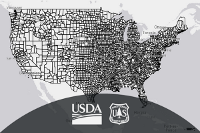

In [72]:
known_item = gis.content.get("d8d3db28fe72445aa0449cfbcd6d0da3")
known_item

Join the published points to the counties spatially

In [91]:
f1 = known_item.layers[0]
#sdf = pandas.DataFrame.spatial.from_layer(f1)
f2 = published_service.layers[0]

arcgis.features.analysis.join_features(f1, f2, spatial_relationship='intersects', spatial_relationship_distance=None, spatial_relationship_distance_units=None, attribute_relationship=None, join_operation='JoinOneToOne', summary_fields=None, output_name='joined_covid_counties', context=None, gis=gis)

<Item title:"joined_covid_counties" type:Feature Layer Collection owner:jill.kelly_yalemaps>

display

In [95]:
search_result = gis.content.search(query="title:joined_covid_counties", item_type="Feature Layer")
f3 = search_result[0].layers[0]
map1 = gis.map('USA', zoomlevel=4)
map1.basemap = 'topo'
map1.add_layer(f3, {"renderer":"ClassedColorRenderer", "field_name": "confirmed"})
#map1.add_layer(known_item)
map1

MapView(layout=Layout(height='400px', width='100%'), zoom=4.0)

In [93]:
f3

<FeatureLayer url:"https://services1.arcgis.com/7uJv7I3kgh2y7Pe0/arcgis/rest/services/joined_covid_counties/FeatureServer/0">

Multiple dates

In [103]:
def flow(DASHDATE):
    df = pandas.read_csv('TEMP_' + DASHDATE + '.txt')
    df.columns = ['FIPS','Admin2','Province_State','Country_Region','Last_Update','Lat','Long','Confirmed','Deaths','Recovered','Active','Combined_Key']
    # in order to later have join key that matches:
    #df['Combined_Key'] = df['Combined_Key'].str[:-4]

    # non-ArcGIS python API means of creating shapefile from csv
    geometry = [Point(xy) for xy in zip(df.Long, df.Lat)]
    prj_file = geopandas.datasets.get_path('naturalearth_cities').replace(".shp",".prj")
    prj = [l.strip() for l in open(prj_file,'r')][0]
    gdf = geopandas.GeoDataFrame(df, crs=crs, geometry=geometry)
    gdf.to_file(filename='/Users/kit/shps/TEMP.shp', driver='ESRI Shapefile', crs_wkt=prj)

    #zip it for upload
    shutil.make_archive("shps_zipped_" + DASHDATE, 'zip', '/Users/kit/shps')
    
    data = '/Users/kit/shps/shps_zipped_ + DASHDATE.zip'

    shpfile = gis.content.add({}, data)
    published_service = shpfile.publish()
    
    f1 = known_item.layers[0]

    f2 = published_service.layers[0]

    arcgis.features.analysis.join_features(f1, f2, spatial_relationship='intersects', spatial_relationship_distance=None, spatial_relationship_distance_units=None, attribute_relationship=None, join_operation='JoinOneToOne', summary_fields=None, output_name='joined_'+DASHDATE, context=None, gis=gis)

    return()

In [104]:
for dashdate in dashdatelist[1:]: flow(dashdate)

RuntimeError: Specify type in item_properties